In [1]:
# =============================================================================
# Environment Setup and GPU Configuration
# =============================================================================
import tensorflow as tf
from functions import *
from ppg_functions import *
tf.random.set_seed(42)
np.random.seed(42)

mask_unused_gpus()

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

2025-08-08 17:30:11.572879: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754667011.585752   64839 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754667011.589564   64839 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-08 17:30:11.604182: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Set the following GPU(s) to be visible: 0
Tensorflow session initialized


I0000 00:00:1754667034.562756   64839 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43607 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:2f:00.0, compute capability: 8.6


In [2]:
# =============================================================================
# Data Loading and Preprocessing for MIMIC_PERFORM Dataset
# =============================================================================

import scipy.io as sio
import numpy as np

# Load .mat file containing patient data
mat_data = sio.loadmat('../Datasets/MIMIC_PERFORM/mimic_perform_train_all_data.mat')

fs = 125  # Sampling frequency
X = []  # List to store PPG signals
condition = []  # List to store patient categories


for i in range(mat_data['data'].shape[1]):
    data = mat_data['data']
    # Extract PPG signal for the patient and convert to list
    patient_ppg = data[0, i]['ppg'][0, 0]['v'].T.tolist()[0]
    # Extract patient category from 'fix' field
    patient_category = data[0, i]['fix'][0, 0][-1][0]
    X.append(patient_ppg)
    condition.append(patient_category)

# Map each unique category string to a unique integer
condition_mapping = {label: idx for idx, label in enumerate(set(condition))}

# Convert category strings to integer labels using the mapping
y = [condition_mapping[label] for label in condition]
labels = list(condition_mapping.keys())
X_raw = np.array(X)


In [3]:
# =============================================================================
# PPG Data Preparation and Preprocessing
# =============================================================================

from ppg_functions import *

# Desired sampling frequency for resampling
desired_fs = 100

# FFT parameters
nfft = 1024
fs = 125  # Original sampling frequency
ff = [0.67, 8]  # Frequency range for filtering

# Prepare data: resample, compute spectrums, and residuals
X, spectrums, residuals = prepare_data(X_raw, y, fs, desired_fs, ff, nfft)

# Window and overlap settings for segmentation
window_size = 85
overlap_size = 24
w = window_size
o = overlap_size
# Validation and test split proportions
validation_proportion = 0.10
test_proportion = 0.25

# Segment and split the data into train, validation, and test sets
Xtr, Ytr, Xval, Yval, Xts, Yts, signalsTR, signalsVAL, signalsTS, Itr, Ival, Its = process_data(
    X, y, windows=window_size, overlap=overlap_size, val=validation_proportion, test=test_proportion
)

100%|██████████| 200/200 [00:01<00:00, 158.47it/s]


Train labels: (array([0, 1]), array([63765, 63765]))
Val labels: (array([0, 1]), array([9810, 9810]))
Test labels: (array([0, 1]), array([24525, 24525]))


In [4]:
# =============================================================================
# Autoencoder Training for MIMIC_PERFORM Dataset
# =============================================================================

folder = 'Output/'
Otr = Xtr
Oval = Xval
Ots = Xts
experiment_name = 'MIMIC_AE'
architecture_options = [
    [[], 3, []]
]
activation_functions = ['tanh']
learning_rates = [0.001]
batch_sizes = [64]
n_splits = 1
epochs = 500
force_train = False

# Train autoencoder model and obtain hidden representations
best_autoencoder_model, best_autoencoder_config, errors, Htr_AE, Hval_AE, Hts_AE = train_AE(
    folder,
    0,
    Xtr,
    Otr,
    Ytr,
    Xval,
    Oval,
    Yval,
    Xts,
    Ots,
    Yts,
    labels,
    experiment_name,
    architecture_options,
    activation_functions,
    learning_rates,
    batch_sizes,
    n_splits,
    epochs,
    force_train
)


MIMIC_AE.pkl file exists


I0000 00:00:1754667038.166062   64839 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43607 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:2f:00.0, compute capability: 8.6


{'architecture': [[], 3, []], 'lr': 0.001, 'batch_size': 64, 'activation': 'tanh'}
  83/3986 ━━━━━━━━━━━━━━━━━━━━ 2s 615us/step   

I0000 00:00:1754667038.893204  110307 service.cc:148] XLA service 0x7f53380035d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754667038.893239  110307 service.cc:156]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2025-08-08 17:30:38.899273: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754667038.911227  110307 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1754667038.991083  110307 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3986/3986 ━━━━━━━━━━━━━━━━━━━━ 3s 603us/step
614/614 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 1s 634us/step


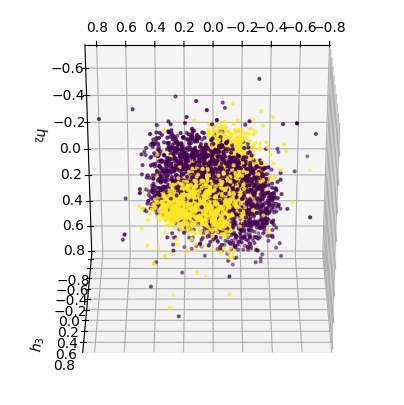

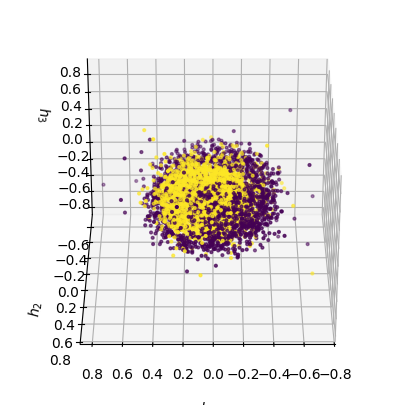

In [5]:
# =============================================================================
# 3D Visualization of Autoencoder Embeddings (MIMIC_PERFORM Dataset)
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

def sample_array(X, Y, percentage=0.10):
    """
    Randomly sample a percentage of rows from X and corresponding labels from Y.

    Parameters
    ----------
    X : np.ndarray
        Array of data samples.
    Y : np.ndarray or list
        Array or list of labels corresponding to X.
    percentage : float, optional
        Fraction of samples to select (default is 0.10).

    Returns
    -------
    X_sampled : np.ndarray
        Sampled data array.
    Y_sampled : np.ndarray or list
        Sampled labels.
    """
    num_samples = int(X.shape[0] * percentage)
    selected_indices = np.random.choice(X.shape[0], num_samples, replace=False)
    return X[selected_indices], Y[selected_indices]

# Sample 30% of the test set embeddings and labels for visualization
Hts_AE_sampled, Yts_sampled = sample_array(Hts_AE, Yts, 0.10)

# --- First 3D scatter plot: elevation 120°, azimuth 90° ---
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(
    Hts_AE_sampled[:, 0], Hts_AE_sampled[:, 1], Hts_AE_sampled[:, 2],
    c=Yts_sampled, cmap='viridis', s=4
)

# Set axis labels using LaTeX formatting
ax.set_xlabel(r'$h_1$', labelpad=10)
ax.set_ylabel(r'$h_2$', labelpad=10)
ax.set_zlabel(r'$h_3$', labelpad=10)

# Set viewing angle for optimal separation of clusters
ax.view_init(elev=120, azim=90)

# Save the figure at high resolution
plt.savefig("./Figures/MIMIC_PERFORM_AE_EMBD_1.png", dpi=800, bbox_inches='tight')
plt.show()

# --- Second 3D scatter plot: elevation 30°, azimuth 90° ---
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(
    Hts_AE_sampled[:, 0], Hts_AE_sampled[:, 1], Hts_AE_sampled[:, 2],
    c=Yts_sampled, cmap='viridis', s=4
)

ax.set_xlabel(r'$h_1$', labelpad=10)
ax.set_ylabel(r'$h_2$', labelpad=10)
ax.set_zlabel(r'$h_3$', labelpad=10)

ax.view_init(elev=30, azim=90)

plt.savefig("./Figures/MIMIC_PERFORM_AE_EMBD_2.png", dpi=800, bbox_inches='tight')
plt.show()

In [25]:
# =============================================================================
# SVM Classification on Autoencoder Embeddings (MIMIC_PERFORM Dataset)
# =============================================================================

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from tqdm import tqdm

# Use autoencoder embeddings for training and testing
Xtr = Htr_AE
Xts = Hts_AE

# Train SVC 
#best_svc = SVC(C=1000, gamma=10, kernel='rbf')
#best_svc.fit(Xtr, Ytr)

from cuml.svm import SVC as cuSVC
best_svc = cuSVC(C=1000, gamma=10, kernel='rbf')
best_svc.fit(Xtr, Ytr)


# Predict labels for test signals using autoencoder and SVC
yTS = []
for signal in tqdm(signalsTS):
    # Buffer the signal for windowed embedding extraction
    buff = buffer_signal(signal, w, o)
    # Obtain embeddings using the encoder part of the autoencoder
    embdd = best_autoencoder_model.layers[0].predict(buff)
    # Predict labels for each window
    predict = best_svc.predict(embdd)
    # Use the most frequent predicted label for the signal
    yTS.append(max(set(predict), key=list(predict).count))

# Predict labels for training signals using autoencoder and SVC
yTR = []
for signal in tqdm(signalsTR):
    buff = buffer_signal(signal, w, o)
    embdd = best_autoencoder_model.layers[0].predict(buff)
    predict = best_svc.predict(embdd)
    yTR.append(max(set(predict), key=list(predict).count))


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


100%|██████████| 50/50 [00:06<00:00,  8.17it/s]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


100%|██████████| 130/130 [00:15<00:00,  8.27it/s]


In [26]:
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, recall_score

# =============================================================================
# Evaluation on Training Set
# =============================================================================
print("Training Set Report:")
y_train_true = np.array(y)[Itr]
y_train_pred = yTR

print(classification_report(y_train_true, y_train_pred, target_names=labels))

sensitivity = recall_score(y_train_true, y_train_pred, pos_label=1)
specificity = recall_score(y_train_true, y_train_pred, pos_label=0)

g_mean_binary = np.sqrt(sensitivity * specificity)
print(f"G-Mean (Train): {g_mean_binary:.4f}")
auc = roc_auc_score(y_train_true, y_train_pred)
print(f"AUC: {auc:.4f}")
# =============================================================================
# Evaluation on Test Set
# =============================================================================
print("\nTest Set Report:")
y_test_true = np.array(y)[Its]
y_test_pred = yTS

print(classification_report(y_test_true, y_test_pred, target_names=labels))

sensitivity = recall_score(y_test_true, y_test_pred, pos_label=1)
specificity = recall_score(y_test_true, y_test_pred, pos_label=0)

g_mean_binary = np.sqrt(sensitivity * specificity)
print(f"G-Mean (Test): {g_mean_binary:.4f}")
auc = roc_auc_score(y_test_true, y_test_pred)
print(f"AUC: {auc:.4f}")


Training Set Report:
              precision    recall  f1-score   support

           n       0.88      0.97      0.92        65
           a       0.97      0.86      0.91        65

    accuracy                           0.92       130
   macro avg       0.92      0.92      0.92       130
weighted avg       0.92      0.92      0.92       130

G-Mean (Train): 0.9138
AUC: 0.9154

Test Set Report:
              precision    recall  f1-score   support

           n       0.88      0.92      0.90        25
           a       0.92      0.88      0.90        25

    accuracy                           0.90        50
   macro avg       0.90      0.90      0.90        50
weighted avg       0.90      0.90      0.90        50

G-Mean (Test): 0.8998
AUC: 0.9000


In [ ]:
# =============================================================================
# UMAP Embedding Training for MIMIC_PERFORM Dataset
# =============================================================================

# List of patient indices for reference
y_patients = list(range(len(X_raw)))

folder = 'Output/'
experiment_name = 'MIMIC_UMAPU'
n_neighbors = [100]
min_dist = [0.3]
n_components = 3
n_splits = 1
force_train = False

# Train UMAP model and obtain embeddings for train, validation, and test sets
best_umap_instance, best_UMAP_config, errors, Htr_umap, Hval_umap, Hts_umap = train_umap(
    folder,
    0,
    Xtr,
    Ytr,
    Xval,
    Yval,
    Xts,
    Yts,
    experiment_name,
    labels,
    n_neighbors,
    min_dist,
    n_components,
    n_splits,
    force_train,
    metric='euclidean'
)


MIMIC_UMAPU.pkl file exists
{'n_neighbors': 100, 'n_components': 3, 'min_dist': 0.3}
David-Bouldin index for UMAP (Test): 29.4296740644699


In [27]:
# =============================================================================
# SVM Classification on UMAP Embeddings (MIMIC_PERFORM Dataset)
# =============================================================================

# Use UMAP embeddings for training and testing
Xtr = Htr_umap
Xts = Hts_umap

#from sklearn.svm import SVC
#best_svc = SVC(C=1000, gamma=10, kernel='rbf', probability=False)
#best_svc.fit(Xtr, Ytr)

from cuml.svm import SVC as cuSVC
best_svc = cuSVC(C=1000, gamma=10, kernel='rbf')
best_svc.fit(Xtr, Ytr)


SVC()

In [29]:
def predict_majority_label(signals, umap_instance, svc_model, window_size, overlap_size):
    """
    Predicts the majority class label for each signal using UMAP embeddings and SVC.

    Parameters
    ----------
    signals : list of np.ndarray
        List of raw signals to classify.
    umap_instance : UMAP
        Trained UMAP instance for embedding transformation.
    svc_model : sklearn.svm.SVC
        Trained SVC classifier.
    window_size : int
        Window size for buffering signals.
    overlap_size : int
        Overlap size for buffering signals.

    Returns
    -------
    list
        Predicted majority class labels for each signal.
    """
    predictions = []
    for signal in tqdm(signals):
        # Buffer the signal for windowed embedding extraction
        buff = buffer_signal(signal, window_size, overlap_size)
        # Obtain UMAP embeddings for each window
        embdd = umap_instance.transform(buff)
        # Predict labels for each window
        window_preds = svc_model.predict(embdd)
        # Use the most frequent predicted label for the signal
        majority_label = max(set(window_preds), key=list(window_preds).count)
        predictions.append(majority_label)
    return predictions

# Predict labels for test and train signals using UMAP and SVC
yTS = predict_majority_label(signalsTS, best_umap_instance, best_svc, w, o)
yTR = predict_majority_label(signalsTR, best_umap_instance, best_svc, w, o)


100%|██████████| 130/130 [01:45<00:00,  1.24it/s]


In [ ]:

import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, recall_score

# =============================================================================
# Evaluation on Training Set
# =============================================================================
print("Training Set Report:")
y_train_true = np.array(y)[Itr]
y_train_pred = yTR

print(classification_report(y_train_true, y_train_pred, target_names=labels))

sensitivity = recall_score(y_train_true, y_train_pred, pos_label=1)
specificity = recall_score(y_train_true, y_train_pred, pos_label=0)

g_mean_binary = np.sqrt(sensitivity * specificity)
print(f"G-Mean (Train): {g_mean_binary:.4f}")
auc = roc_auc_score(y_train_true, y_train_pred)
print(f"AUC: {auc:.4f}")
# =============================================================================
# Evaluation on Test Set
# =============================================================================
print("\nTest Set Report:")
y_test_true = np.array(y)[Its]
y_test_pred = yTS

print(classification_report(y_test_true, y_test_pred, target_names=labels))

sensitivity = recall_score(y_test_true, y_test_pred, pos_label=1)
specificity = recall_score(y_test_true, y_test_pred, pos_label=0)

g_mean_binary = np.sqrt(sensitivity * specificity)
print(f"G-Mean (Test): {g_mean_binary:.4f}")
auc = roc_auc_score(y_test_true, y_test_pred)
print(f"AUC: {auc:.4f}")


Training Set Report:
              precision    recall  f1-score   support

           n       0.00      0.00      0.00        65
           a       0.50      1.00      0.67        65

    accuracy                           0.50       130
   macro avg       0.25      0.50      0.33       130
weighted avg       0.25      0.50      0.33       130

G-Mean (Train): 0.0000
AUC: 0.5000

Test Set Report:
              precision    recall  f1-score   support

           n       0.00      0.00      0.00        25
           a       0.50      1.00      0.67        25

    accuracy                           0.50        50
   macro avg       0.25      0.50      0.33        50
weighted avg       0.25      0.50      0.33        50

G-Mean (Test): 0.0000
AUC: 0.5000
